# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [19]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [1]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
# import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [2]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [3]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [4]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32, 3)


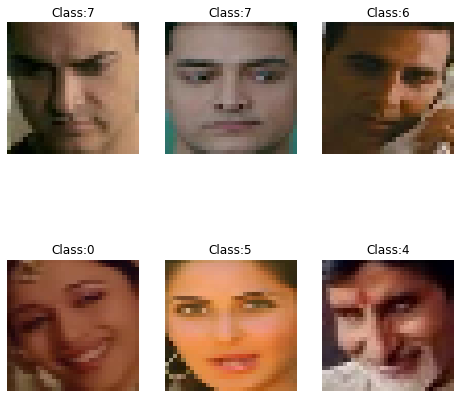

In [5]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [6]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [7]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k, pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [8]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=True,remove_zero_eig=True)
    X_k = kpca.fit_transform(X)
#     print(X_k.shape)
    return X_k, kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [9]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k, lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [10]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @paraget_kernel_pca(X, k)m: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k, klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [11]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [12]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Eigenfaces is the name given to a set of eigenvectors when they are used in human face recognition.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [13]:
# Compute your features 
# eg.
X_3D, klda = get_kernel_lda(X,y,3)

c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


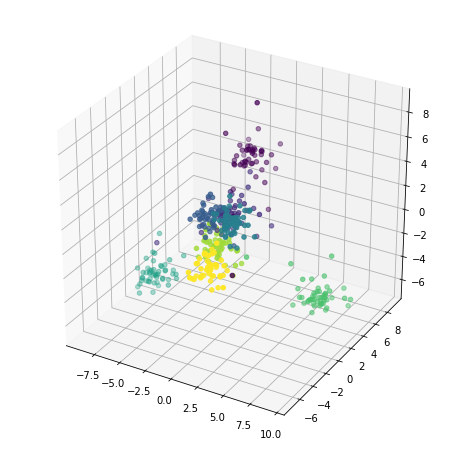

In [14]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

(3072, 3072)


c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


No of eigen values greater than zero:  1734


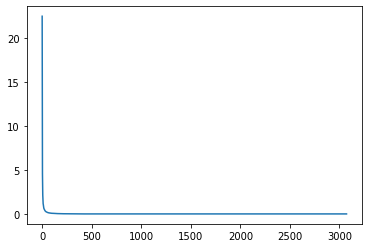

In [15]:
# Plot the eigen value spectrum
co = np.cov(X.T)
print(co.shape)
e, w = np.linalg.eig(co)
plt.plot(e)
count = 0
for i in range(e.shape[0]):
    if e[i] > 0:
        count = count + 1
print('No of eigen values greater than zero: ',count)

1(c). Reconstruct  the  image  back for each case


In [17]:
# <input_parameters>,*args,**kwargs
def reconstruct_images(X,y,k,p):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
        
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    if p == 1:
        # For linear PCA
        x_k, pca = get_pca(X, k)
        x1 = pca.inverse_transform(x_k)*255
    if p == 2:
        # for kernel PCA
        x_k, kpca = get_kernel_pca(X, k)
        x1 = kpca.inverse_transform(x_k)*255
    if p == 3:
        # for linear LDA
        x_k, lda = get_lda(X,y,k)
        inv = np.linalg.pinv(lda.scalings_)
        #lda.scalling_ returns the eigen vectors used in inverse transform
        #lda.xbar_ gets the overall mean
        x1 = np.dot(x_k, inv) + lda.xbar_
        x1 = x1*255
    if p == 4:
        # for kernel LDA
        x_k, klda = get_kernel_lda(X, y, k)
        inv = np.linalg.pinv(klda.scalings_)
        #lda.scalling_ returns the eigen vectors used in inverse transform
        #lda.xbar_ gets the overall mean
        x1 = np.dot(x_k, inv) + klda.xbar_
        x1 = x1*255
        
    pass
    reconstruct_X = np.int_(x1)
    
    return reconstruct_X    

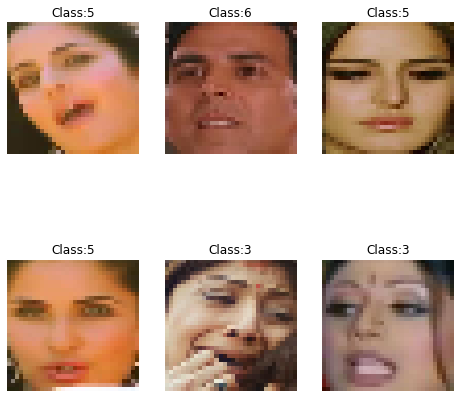

110.05182840626203


In [18]:
# Display results 
X_reconstruced = reconstruct_images(X,y,400,1)
X_reconstruced_3D = X_reconstruced.reshape((N,H,W,C))
# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstruced_3D[ind,...],y[ind],row=2,col=3)
# Show the reconstruction error
print(np.sqrt(np.mean((X - X_reconstruced)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [ ]:
# code goes here

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [32]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
class Classifier():
    def __init__():
        self.model = 0
        self.confusion_matrix = []
        self.prediction = 0
        super.__init__()
        
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        self.prediction = self.model.predict(X)
        return self.prediction
        
    def confusion_mat(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        self.confusion_matrix = confusion_matrix(y, pred)
#         print(self.confusion_matrix)
        
    def train(self,X_train,y_train,p):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        if p == 1:
            # For SVM classification
            self.model = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
        if p == 2:
            # For decision Tree
            self.model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
        if p == 3:
            # for Logistic Regression
            self.model = LogisticRegression(random_state = 0).fit(X_train, y_train)
        if p == 4:
            #For MLP 
            self.model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 15), random_state=1).fit(X_train, y_train)
            
        

        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        
        # Create a confusion matrix
        
        # Calculate Validation accuracy 
        accuracy = self.model.score(X_validate, y_validate)
        # Calculate precision and recall 
        precision, recall, fscore, support = score(y_validate, self.prediction)
        # Calculate F1-score
    
        return precision, recall, fscore, accuracy

In [33]:
# Create a train and validation split to train your classifier 
from sklearn.model_selection import train_test_split


def call_Classifier(X, y, p):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    classifier = Classifier
    classifier.train(classifier, X_train, y_train, p)
    prediction = classifier.classify(classifier, X_test) 
    classifier.confusion_mat(classifier, prediction, y_test)
    precision, recall, fscore, accuracy = classifier.validate(classifier, X_test, y_test)
    return precision, recall, fscore, accuracy, classifier
    

# for SVM Classifier
precisionSVM, recallSVM, fscoreSVM, accuracySVM, objSVM = call_Classifier(X, y, 1)

# For Decision Tree Method
precisionDT, recallDT, fscoreDT, accuracyDT, objDT = call_Classifier(X, y, 2)

# For Logistic Regression
precisionLR, recallLR, fscoreLR, accuracyLR, objLR = call_Classifier(X, y, 3)
# For MLP
precisionMLP, recallMLP, fscoreMLP, accuracyMLP, objMLP = call_Classifier(X, y, 4)

c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
def create_table(X, y, dirpath):
    X_kpca, kpca = get_kernel_pca(X, 100)
    X_vgg = get_vgg_features(dirpath)
    X_resnet = get_resnet_features(dirpath)
    X_klda, klda = get_kernel_lda(X,y,100)
    # KPCA + SVM
    precisionSVM_KPCA, recallSVM_KPCA, fscoreSVM_KPCA, accuracySVM_KPCA, objSVM_KPCA = call_Classifier(X_kpca, y, 1)

    #VGG + MLP
    precisionMLP_VGG, recallMLP_VGG, fscoreMLP_VGG, accuracyMLP_VGG, objMLP_VGG = call_Classifier(X_vgg, y, 4)

    #VGG + SVM
    precisionSVM_VGG, recallSVM_VGG, fscoreSVM_VGG, accuracySVM_VGG, objSVM_VGG = call_Classifier(X_vgg, y, 1)

    #(KPCA + KLDA) + LR
    X_train = np.append(X_kpca, X_klda, axis=1)
    precisionLR, recallLR, fscoreLR, accuracyLR, objLR = call_Classifier(X_train, y, 3)

    #(Resnet+ VGG) + SVM
    X_train = np.append(X_resnet, X_vgg, axis = 1)
    precisionSVM_VR, recallSVM_VR, fscoreSVM_VR, accuracySVM_VR, objSVM_VR = call_Classifier(X_train, y, 1)

    #all
    X_train = np.append(X_kpca, X_klda, axis=1)
    X_train = np.append(X_train, X_vgg, axis=1)
    X_train = np.append(X_train, X_resnet, axis=1)
    # print(X_train.shape)
    precisionSVM_ALL, recallSVM_ALL, fscoreSVM_ALL, accuracySVM_ALL, objALL = call_Classifier(X_train, y, 1)

    # Create 3 tables simiar to page-6 of the paper. One table per dataset 
    # Each table will have 5 columns. 
    # Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

    # Print the table. (You can use Pandas)
    print('Method           |Space|Error |Accuracy|F1-Score(macro-F1)')
    print('-----------------------------------------------------------')
    print('KPA + SVM        |100  |',round((1-accuracySVM_KPCA),2),'|',round(accuracySVM_KPCA, 2),'  |',np.mean(fscoreSVM_KPCA))
    print('-----------------------------------------------------------')
    print('VGG + MLP        |4096 |',round((1-accuracyMLP_VGG),2),'|',round(accuracyMLP_VGG, 2),'  |',np.mean(fscoreMLP_VGG))
    print('-----------------------------------------------------------')
    print('VGG + SVM        |4096 |',round((1-accuracySVM_VGG),2),'|',round(accuracySVM_VGG,2),'  |',np.mean(fscoreSVM_VGG))
    print('-----------------------------------------------------------')
    print('(KPCA + KLDA)+ LR|107  |',round((1-accuracyLR),2),'|',round(accuracyLR,2),'  |',np.mean(fscoreLR))
    print('-----------------------------------------------------------')
    print('(Resnet+ VGG)+SVM|6144 |',round((1-accuracySVM_VR),2),'|',round(accuracySVM_VR,2),'  |',np.mean(fscoreSVM_VR))
    print('-----------------------------------------------------------')
    print('All Features +SVM|6251 |',round((1-accuracySVM_ALL),2),'|',round(accuracySVM_ALL,2),'  |',np.mean(fscoreSVM_ALL))
    print('-----------------------------------------------------------')




iiit_cfw = './dataset/IIIT-CFW/'  # IIIT-CFW, IMFDB, Yale_face_database
X,y=dataset(iiit_cfw)
create_table(X, y, iiit_cfw)

imfdb = './dataset/IMFDB/'  # IIIT-CFW, IMFDB, Yale_face_database
X,y=dataset(imfdb)
create_table(X, y, imfdb)

yale = './dataset/Yale_face_database/'  # IIIT-CFW, IMFDB, Yale_face_database
X,y=dataset(yale)
create_table(X, y, yale)

In [53]:
# For each dataset print the confusion matrix for the best model 
print(objSVM.confusion_mat)

<function Classifier.confusion_mat at 0x0F1A1030>


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

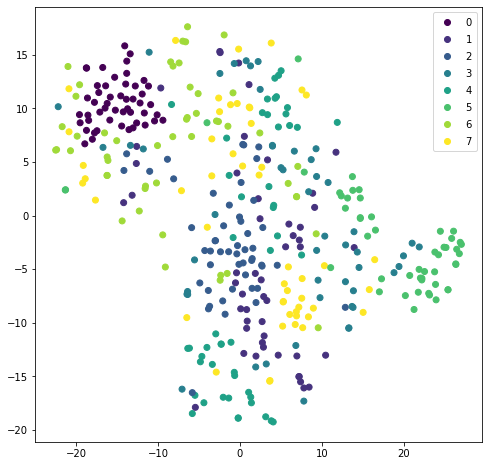

In [38]:
# Compute TSNE for different features and create a scatter plot

X = X # feature 
k = 2 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X)

# Plot the representation in 2d/3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y,)
ax.legend(*scatter.legend_elements())

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [39]:
from sklearn.neighbors import KNeighborsClassifier
class FaceVerification():
    def __init__():
        super.__init__()
        self.predicted = 0
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        self.predicted=self.predict(X)
        verification = np.zeros(self.predicted.shape)
        for i in range(self.predicted.shape[0]):
            if(self.predicted[i] == class_id[i]):
                verification[i] = 1
        return verification
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        accuracy = self.score(X_validate, y_validate) 
        #Computing accuracy, recall, F1-score, support
        precision, recall, fscore, support = score(y_validate, self.predicted)

        return  accuracy,precision,recall,fscore 

In [40]:
# Create a train and validation split and show your results 
def call_Classifier(classifier, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    facevar = FaceVerification
    facevar.train(classifier, X_train, y_train)
    verification_results = facevar.verify(classifier, X_test, y_test)
    accuracy, precision, recall, fscore = facevar.validate(classifier, X_test, y_test)
    return accuracy, precision, recall, fscore
    
def KNN(X,y,k,dirpath):
    X_kpca, kpca = get_kernel_pca(X, 100)
    X_vgg = get_vgg_features(dirpath)
    X_resnet = get_resnet_features(dirpath)
    X_klda, klda = get_kernel_lda(X,y,100)
    knn = KNeighborsClassifier(n_neighbors=k)
    #KPCA + KNN
    accuracy_Kpca, precision_Kpca, recall_Kpca, fscore_Kpca = call_Classifier(knn, X_kpca, y)
    #VGG + KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy_VGG, precision_VGG, recall_VGG, fscore_VGG = call_Classifier(knn, X_vgg, y)
    #(KPCA + KLDA) + LR
    X_KK = np.append(X_kpca, X_klda, axis=1)
    accuracy_KK, precision_KK, recall_KK, fscore_KK = call_Classifier(knn, X_KK, y)
    #(Resnet+ VGG) + SVM
    X_RV = np.append(X_resnet, X_vgg, axis = 1)
    accuracy_RV, precision_RV, recall_RV, fscore_RV = call_Classifier(knn, X_RV, y)
    #all
    X_all = np.append(X_kpca, X_klda, axis=1)
    X_all = np.append(X_all, X_vgg, axis=1)
    X_all = np.append(X_all, X_resnet, axis=1)
    accuracy_all, precision_all, recall_all, fscore_all = call_Classifier(knn, X_all, y)
    print('For dataset: ', dirpath)
    print('Method           |Space|Error |Accuracy|F1-Score(macro-F1)')
    print('-----------------------------------------------------------')
    print('KPA + KNN        |100  |',round((1-accuracy_Kpca),2),'|',round(accuracy_Kpca, 2),'  |',np.mean(fscore_Kpca))
    print('-----------------------------------------------------------')
    print('VGG + KNN        |4096 |',round((1-accuracy_VGG),2),'|',round(accuracy_VGG,2),'  |',np.mean(fscore_VGG))
    print('-----------------------------------------------------------')
    print('(KPCA + KLDA)+KNN|107  |',round((1-accuracy_KK),2),'|',round(accuracy_KK, 2),'  |',np.mean(fscore_KK))
    print('-----------------------------------------------------------')
    print('(Resnet+ VGG)+KNN|6144 |',round((1-accuracy_RV),2),'|',round(accuracy_RV, 2),'  |',np.mean(fscore_RV))
    print('-----------------------------------------------------------')
    print('All Features +KNN|6251 |',round((1-accuracy_all),2),'|',round(accuracy_all,2),'  |',np.mean(fscore_all))
    print('-----------------------------------------------------------')

In [41]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
def dataset(dirpath):
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    return X,y

iiit_cfw = './dataset/IIIT-CFW/'  # IIIT-CFW, IMFDB, Yale_face_database
X,y=dataset(iiit_cfw)
KNN(X,y,9,iiit_cfw)

imfdb = './dataset/IMFDB/'  # IIIT-CFW, IMFDB, Yale_face_database
X,y=dataset(imfdb)
KNN(X,y,7,imfdb)

yale = './dataset/Yale_face_database/'  # IIIT-CFW, IMFDB, Yale_face_database
X,y=dataset(yale)
KNN(X,y,5,yale)
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)

Dataset shape: (672, 32, 32, 3)


c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


For dataset:  ./dataset/IIIT-CFW/
Method           |Space|Error |Accuracy|F1-Score(macro-F1)
-----------------------------------------------------------
KPA + KNN        |100  | 0.56 | 0.44   | 0.4374848455258772
-----------------------------------------------------------
VGG + KNN        |4096 | 0.27 | 0.73   | 0.6769294169024245
-----------------------------------------------------------
(KPCA + KLDA)+KNN|107  | 0.05 | 0.95   | 0.9355800043964938
-----------------------------------------------------------
(Resnet+ VGG)+KNN|6144 | 0.02 | 0.98   | 0.9767800927816113
-----------------------------------------------------------
All Features +KNN|6251 | 0.02 | 0.98   | 0.9814113106203763
-----------------------------------------------------------
Dataset shape: (400, 32, 32, 3)


c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


For dataset:  ./dataset/IMFDB/
Method           |Space|Error |Accuracy|F1-Score(macro-F1)
-----------------------------------------------------------
KPA + KNN        |100  | 0.51 | 0.49   | 0.4818910748544616
-----------------------------------------------------------
VGG + KNN        |4096 | 0.13 | 0.87   | 0.8681275382226469
-----------------------------------------------------------
(KPCA + KLDA)+KNN|107  | 0.04 | 0.96   | 0.9565844481605351
-----------------------------------------------------------
(Resnet+ VGG)+KNN|6144 | 0.03 | 0.97   | 0.971024103332949
-----------------------------------------------------------
All Features +KNN|6251 | 0.02 | 0.98   | 0.9802548725637181
-----------------------------------------------------------
Dataset shape: (165, 32, 32, 3)


c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 15 - 1) = 14 components.
  ChangedBehaviorWarning)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarnin

For dataset:  ./dataset/Yale_face_database/
Method           |Space|Error |Accuracy|F1-Score(macro-F1)
-----------------------------------------------------------
KPA + KNN        |100  | 0.17 | 0.83   | 0.8600529100529101
-----------------------------------------------------------
VGG + KNN        |4096 | 0.57 | 0.43   | 0.40253968253968253
-----------------------------------------------------------
(KPCA + KLDA)+KNN|107  | 0.0 | 1.0   | 1.0
-----------------------------------------------------------
(Resnet+ VGG)+KNN|6144 | 0.02 | 0.98   | 0.9733333333333334
-----------------------------------------------------------
All Features +KNN|6251 | 0.0 | 1.0   | 1.0
-----------------------------------------------------------


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [ ]:
# Load data

In [ ]:
# Define your features

In [ ]:
# Create your classifier

# Validate your classifier

In [ ]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  

In [ ]:
# Show quantitative results such as examples of correct prediction and wrong prediction